# 다양한 OCR모델 비교하기

## Step1. 검증용 데이터셋 준비

In [4]:
import os
import keras_ocr
import pytesseract
from pytesseract import Output
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import glob

In [17]:
images = glob.glob(str('./ocr_python/test_image/*.png'))
images

['./ocr_python/test_image/test_image_08.png',
 './ocr_python/test_image/test_image_02.png',
 './ocr_python/test_image/test_image_01.png',
 './ocr_python/test_image/test_image_03.png',
 './ocr_python/test_image/test_image_09.png',
 './ocr_python/test_image/test_image_07.png',
 './ocr_python/test_image/test_image_05.png',
 './ocr_python/test_image/test_image_10.png',
 './ocr_python/test_image/test_image_06.png',
 './ocr_python/test_image/test_image_04.png']

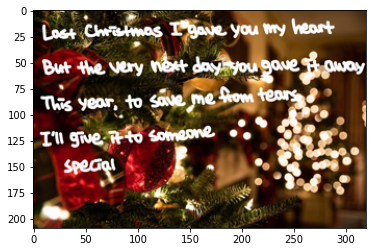

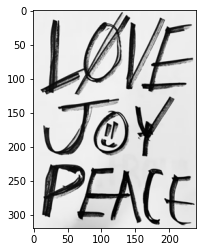

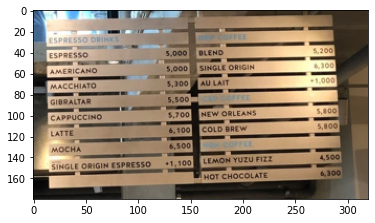

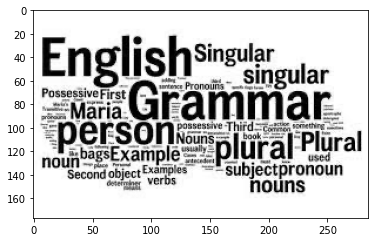

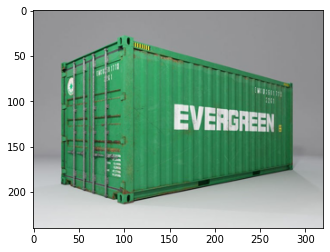

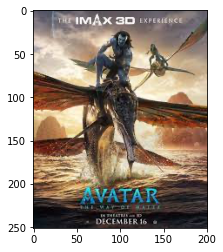

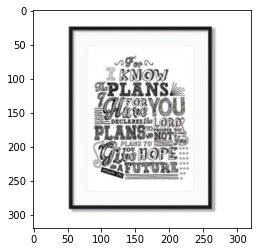

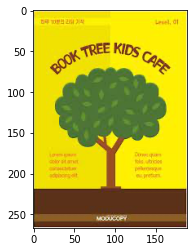

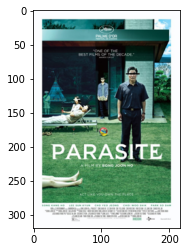

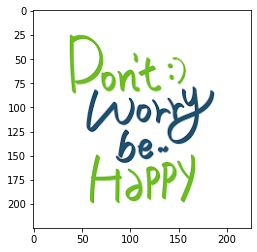

In [18]:
# 테스트 이미지 불러오기 및 시각화
for fname in images:
    image = cv2.imread(fname)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

## Step 2. Google OCR API, keras-ocr, Tesseract로 테스트 진행하기
### (1) Google OCR API

In [19]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [20]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'

google_ocr = []

for fname in images:
    google_ocr.append(detect_text(fname))

Texts:

"Lost Christmas I gave you my heart
But the very next day you gave of away
This year, to save me from tears
I'll give it to someone
Special
PANORMAN"

"Lost"

"Christmas"

"I"

"gave"

"you"

"my"

"heart"

"But"

"the"

"very"

"next"

"day"

"you"

"gave"

"of"

"away"

"This"

"year"

","

"to"

"save"

"me"

"from"

"tears"

"I'll"

"give"

"it"

"to"

"someone"

"Special"

"PANORMAN"
bounds: (183,199),(252,174),(256,187),(188,212)
Texts:

"LØVE
JOY
PEACE"

"LØVE"

"JOY"

"PEACE"
bounds: (12,226),(245,234),(242,313),(9,305)
Texts:

"ESPRESSO DRINKS
ESPRESSO
AMERICANO
MACCHIATO
GIBRALTAR
CAPPUCCINO
LATTE
MOCHA
SINGLE ORIGIN ESPRESSO
5,000
5,000
5,300
5,500
5,700
6,100
6,500
+1,100
DRIP COFFEE
BLEND
SINGLE ORIGIN
AU LAIT
NEW ORLEANS
COLD BREW
ON COFFEE
LEMON YUZU FIZZ
HOT CHOCOLATE
5,200
6,300
+1,000
5,800
5,800
4,500
6,300"

"ESPRESSO"

"DRINKS"

"ESPRESSO"

"AMERICANO"

"MACCHIATO"

"GIBRALTAR"

"CAPPUCCINO"

"LATTE"

"MOCHA"

"SINGLE"

"ORIGIN"

"ESPRESSO"

"5,000"

"5,000

### (2) keras-ocr

In [21]:
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [25]:
image = [keras_ocr.tools.read(fname) for fname in images]
prediction_groups = [pipeline.recognize([fname]) for fname in images]

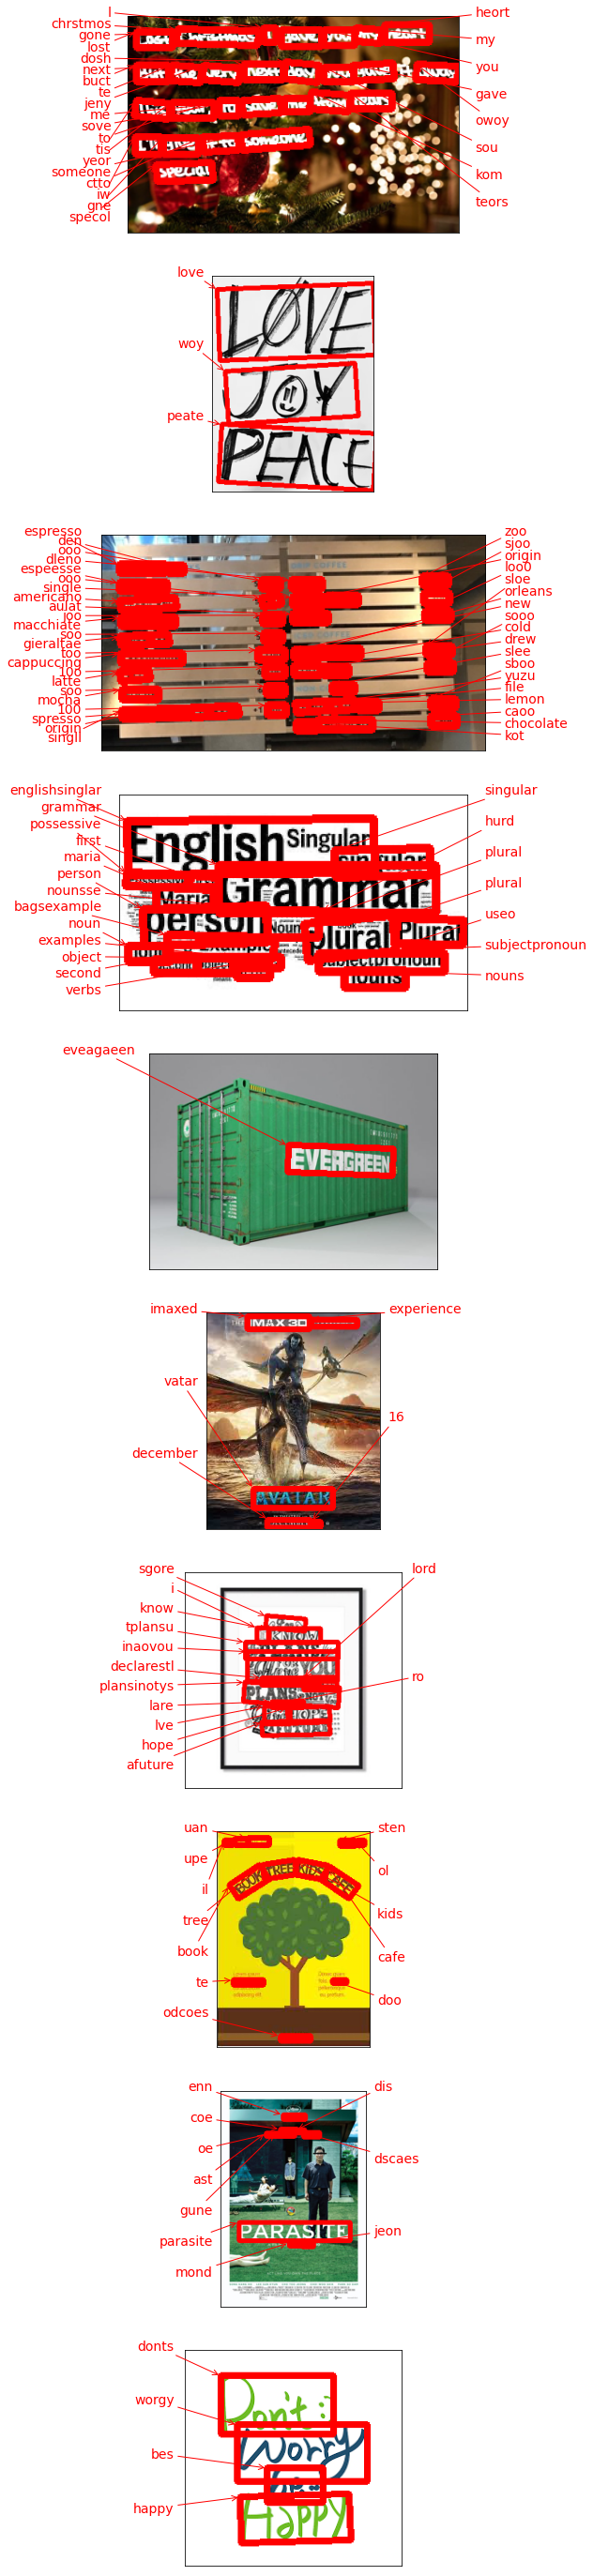

In [29]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(image), figsize=(20, 50))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=image[idx],
                                    predictions=prediction_groups[idx][0], ax=ax)

### (3) Tesseract

In [30]:
# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

In [32]:
for fname in images:
    work_dir = os.getenv('HOME')+'/aiffel/ocr_python/test_image'

    cropped_image_path_list = crop_word_regions(fname, work_dir)

/aiffel/aiffel/ocr_python/test_image/0000.png
/aiffel/aiffel/ocr_python/test_image/0000.png
/aiffel/aiffel/ocr_python/test_image/0000.png
/aiffel/aiffel/ocr_python/test_image/0000.png
/aiffel/aiffel/ocr_python/test_image/0001.png
/aiffel/aiffel/ocr_python/test_image/0002.png
/aiffel/aiffel/ocr_python/test_image/0003.png
/aiffel/aiffel/ocr_python/test_image/0004.png
/aiffel/aiffel/ocr_python/test_image/0005.png
/aiffel/aiffel/ocr_python/test_image/0006.png
/aiffel/aiffel/ocr_python/test_image/0007.png
/aiffel/aiffel/ocr_python/test_image/0008.png
/aiffel/aiffel/ocr_python/test_image/0009.png
/aiffel/aiffel/ocr_python/test_image/0000.png
/aiffel/aiffel/ocr_python/test_image/0000.png
/aiffel/aiffel/ocr_python/test_image/0000.png
/aiffel/aiffel/ocr_python/test_image/0000.png
/aiffel/aiffel/ocr_python/test_image/0000.png
/aiffel/aiffel/ocr_python/test_image/0000.png
/aiffel/aiffel/ocr_python/test_image/0001.png


In [33]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

In [35]:
for fname in images:
    work_dir = os.getenv('HOME')+'/aiffel/ocr_python/test_image'

    cropped_image_path_list = crop_word_regions(fname, work_dir)
    recognize_images(cropped_image_path_list)

/aiffel/aiffel/ocr_python/test_image/0000.png

Done
/aiffel/aiffel/ocr_python/test_image/0000.png

Done
/aiffel/aiffel/ocr_python/test_image/0000.png

Done
/aiffel/aiffel/ocr_python/test_image/0000.png
/aiffel/aiffel/ocr_python/test_image/0001.png
/aiffel/aiffel/ocr_python/test_image/0002.png
/aiffel/aiffel/ocr_python/test_image/0003.png
/aiffel/aiffel/ocr_python/test_image/0004.png
/aiffel/aiffel/ocr_python/test_image/0005.png
/aiffel/aiffel/ocr_python/test_image/0006.png
/aiffel/aiffel/ocr_python/test_image/0007.png
/aiffel/aiffel/ocr_python/test_image/0008.png
/aiffel/aiffel/ocr_python/test_image/0009.png
English! ar


no

seth

cond

object "amp

SUDJCCIVIONOUTT

Doverrnsver

er eo

WuUuns

Done
/aiffel/aiffel/ocr_python/test_image/0000.png
Basle

Done
/aiffel/aiffel/ocr_python/test_image/0000.png

Done
/aiffel/aiffel/ocr_python/test_image/0000.png

Done
/aiffel/aiffel/ocr_python/test_image/0000.png
e

Done
/aiffel/aiffel/ocr_python/test_image/0000.png

Done
/aiff

## Step 3. 테스트 결과 정리

![KakaoTalk_Photo_2023-01-04-01-08-36 001](https://user-images.githubusercontent.com/116326867/210395653-8210aaca-9e09-469a-bd9a-f9a47ed235cb.jpeg)

![KakaoTalk_Photo_2023-01-04-01-08-37 002](https://user-images.githubusercontent.com/116326867/210395772-999f158c-6828-4be5-b29b-cc1a0434f838.jpeg)

- Google OCR API의 경우, 속도도 굉장히 빠르고 정확도도 높은 편이었다. 다만 서비스 계정 및 인증키를 생성하는 과정에서 시간도 오래 걸리고 비용이 발생할 수 있다는 단점이 있었다.  
- Keras-ocr의 경우, 속도는 느리지만 tesseract에 비하면 상대적으로 정확도가 높은 편이었다. 하지만 google ocr api에 비하면 정확도가 떨어지는 편이었다.  
- Tesseract의 경우, 속도는 빠르지만 정확도가 굉장히 많이 떨어졌다. 심지어 아예 문자를 인식하지 못하는 경우도 많았다.  

## Step 4. 결과 분석과 결론 제시

- 속도와 정확도의 면에서 봤을 때 Google OCR API가 가장 높았기 때문에 Google OCR API를 사용하는 것이 가장 합리적이라고 생각했다. 다만, 서비스 계정 및 인증키를 생성하는 과정이 다소 힘들기 때문에 이 과정을 거치고 싶지 않다면 속도는 조금 느려도 정확도가 높은 Keras-ocr을 사용하는 것이 좋을 것이다.

------

## 회고
1. OCR을 활용하여 구현하려는 서비스의 기획이 타당한가?  
어떤 서비스를 기획하려는 건지 알 수가 없어서 타당한 지 여부는 판단하기 힘들 거 같다.  
2. 모델 평가기준이 명확하고 체계적으로 세워졌는가?  
OCR 모델들을 평가하기 위해 속도와 정확성을 기준으로 세웠다. 이 평가기준에 적합한 테스트 데이터는 모두 영문으로 이루어져 있어야 한다는 특징을 가지고 있는 거 같다. Google OCR API의 경우에는 한국어도 잘 읽어내지만 Keras-ocr이나 Tesseract의 경우에는 영문으로 이루어진 것들만 읽어내기 때문이다.  
3. 평가기준에 따라 충분한 분량의 테스트가 진행되고 그 결과가 잘 정리되었는가?  
총 10장의 사진으로 테스트를 진행하였고, 10장으로도 충분히 결과가 잘 나온 거 같다. 각 모델들의 결과가 명확하게 드러난 편인 거 같다.  
4. 프로젝트를 진행하면서 느낀 점: 파일을 불러올 때 굉장히 힘들었는데, 이를 통해서 모델을 평가하는 것보다 평가를 하기 위해 준비하는 과정이 중요하고 힘들다는 사실을 다시 한 번 느끼게 됐던 프로젝트였다.  

## Reference
[폴더 속 이미지 리스트로 가져오기](https://cinema4dr12.tistory.com/1326)